# Training Set Aquisition

## Gregor Fritz and Laurenz Hundgeburth, FH Kärnten Bachelorprojekt

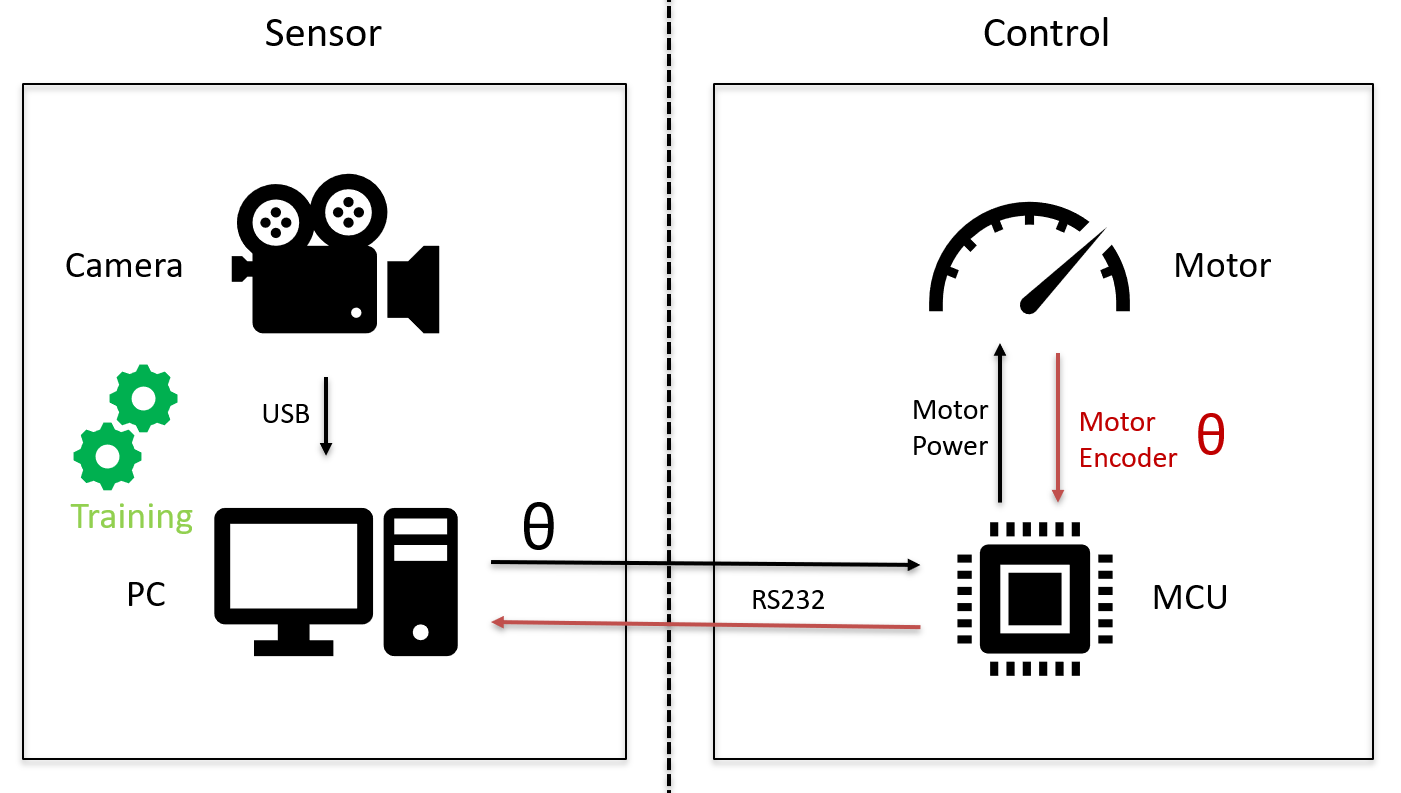

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import csv
import struct
from time import time, sleep
from serial import Serial
from random import randint
from threading import Thread
from tqdm import tqdm
from IPython.display import clear_output

%matplotlib inline

In [2]:
#Class and Function Definitions

################################################################
#Serial Thread

class Ser(Thread):
    def __init__(self, port):
        super().__init__()
        self._run = True
        self._ser = Serial(port ,115200)
        self._last_value = 0.0
        self._reference = 0.0
        self._expected_reference = 0.0
        self._valid = False

    def get_act_value(self):
        return self._last_value
    
    def value_valid(self):
        return self._valid
    
    def write(self, random_rad):
        self._expected_reference += random_rad
        
        for _ in range(10):
            if self._expected_reference == self._reference:
                return
            else:
                self._ser.write(str(self._expected_reference).encode('utf-8'))
                sleep(0.10)
        
        raise IOError('Arduino did not accept reference.')

    def run(self):
        print('Serial Thread running')
        while self._run:
            line = self._ser.readline()
            data = line.split(b',')
            if len(data) != 3:
                raise ValueError('Invalid Data-Length')
                
            self._valid = bool(int(data[0]))
            
            try:
                self._last_value = float(data[1])
                self._reference = float(data[2])
            except ValueError:
                self._last_value = None
                self._reference = None
                self._valid = False
            
            print(self._reference)
            #arduino = str(line).split(',')
            #print(arduino, float(arduino[1]))
            #default reading: "b'1, 1.18/r/n"
            #self._valid = True if (str(line).split(", ")[0].split("'")[1] == '1') else False
            #self._last_value = float(str(line).split(", ")[1].split("\\")[0])
            #print('Serial read: {}, self._valid: {}'.format(str(line), self._valid))
            #print(str(line).split(", ")[0].split("'")[1])

    def end(self):
        self._run = False
        self.join()
        self._ser.close()
        
################################################################
#Camera Thread

class PsEye(Thread):
    def __init__(self):
        super().__init__()
        self._run = True
        self._video = cv2.VideoCapture(0)
        self._last_frame = None

    def get_act_frame(self):
        return self._last_frame

    def run(self):
        while self._run:
            check, frame = self._video.read()
            if check:
                self._last_frame = frame

    def save_last_frame(self, img_file_path, img_name):
        print('Saving img {}'.format(img_name))
        cv2.imwrite(str(img_file_path + img_name), self._last_frame)

    def end(self):
        self._run = False
        self.join()
        self._video.release()

    def frame_valid(self):
        return self._last_frame is not None

################################################################
#Main Functions

def get_label_value():
    for attempt in range(10):
        if ser.value_valid():
            repeat = False
            label = ser.get_act_value()
            label =round(label %(2*np.pi), 2)
            print("got label {}".format(str(label)))
            return (True, label)
        sleep(0.01)
    print("No valid value")
    return (False, None)     
    
def log_csv(file, img_name, label):
    with open(file, 'a') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow([img_name, label])
    pass


Starting Camera Thread...
Camera Thread running...
Saving img test_image.png
closing Threads...


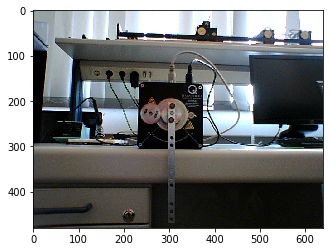

In [12]:
#Camera Image Test
print("\nStarting Camera Thread...")
camera = PsEye()
camera.start()

# Waiting until camera ready
while not camera.frame_valid():
    sleep(0.05)

print('Camera Thread running...')

camera.save_last_frame('./', 'test_image.png')

camera.end()
print("closing Threads...")

img=mpimg.imread('test_image.png')
imgplot = plt.imshow(img)

In [13]:
#Available Ports:
!python -m serial.tools.list_ports

/dev/ttyACM0        
/dev/ttyACM1        
2 ports found


In [14]:
#create new Folder and prepare csv
!mkdir pictures_28_6_19

In [15]:
#create csv 
csvData = [['id', 'label']]

with open('image_labels_28_6_19.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

In [16]:
#Main Programm

port = '/dev/ttyACM1'

csv_file_path = "./image_labels_28_6_19.csv"
img_file_path = "./pictures_28_6_19/"

num_images = 64

print("Starting Serial Thread...")
ser = Ser(port)
ser.start()
sleep(1)

print("\nStarting Camera Thread...")
camera = PsEye()
camera.start()

# Waiting until camera ready
while not camera.frame_valid():
    sleep(0.05)

print('Camera Thread running...')

img_counter = 0
labels = []

for a in tqdm(range(num_images)):
    #clear_output(wait=True)
    rand_increment = randint(100,200) 
    rand_rad = rand_increment/4096 * (2*np.pi)
    ser.write(rand_rad)
    
    while not ser.value_valid():
        sleep(0.01)
    
    (success, label) = get_label_value()
    if success:
        img_name = "{}_{}.png".format(time(), label)
        camera.save_last_frame(img_file_path, img_name)
        log_csv(csv_file_path, img_name, label)
        img_counter += 1
        print('attenpt {} successful!'.format(a+1))
        labels.append(label)
    else:
        print('attenpt {} FAILED!'.format(a+1))
        
print("{} out of {} attempts successful".format(img_counter, num_images))
camera.end()
ser.end()
print("closing Threads...")

Starting Serial Thread...
Serial Thread running

Starting Camera Thread...


  0%|          | 0/64 [00:00<?, ?it/s]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Camera Thread running...
0.0
0.0
0.0


OSError: Arduino did not accept reference.

0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


In [ ]:
#Result Analysis1: Polar Histogramm

bins_number = 16  # the [0, 2pi] interval will be subdivided into this
# number of equal bins
bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
n, _, _ = plt.hist(labels, bins)

plt.clf()
width = 2 * np.pi / bins_number
ax = plt.subplot(1, 1, 1, projection='polar')
bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0)
d_alpha = 0.03
alpha = 0.4
for bar in bars:
    bar.set_alpha(alpha)
    alpha += d_alpha
ax.set_theta_zero_location("S")
#ax.set_theta_direction(-1)
ax.set_title("Label Distribution", va='bottom')
ax.grid(False)
ax.set_rticks([1, 2, 3, 4])
plt.show()

In [ ]:
#Result Analysis2: Random Samples from Dataframe

test = b'1, 1.18/r/n'
test = str(test).split(',')
print(len(test), test, float(test[1]))